In [4]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSSB'
m='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [15]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [5]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.6 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [6]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])
from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [7]:
data_dir='../../Data/Weather'
file_index='SSSBSSSB'

In [8]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [9]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|    13|[30 55 30 55 30 5...|1904.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     3|[28 58 28 58 00 5...|1948.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|    10|[A0 56 40 56 40 5...|1949.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     8|[A0 56 40 56 00 5...|1950.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     7|[28 58 F0 56 00 5...|1951.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [10]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
T = T/10.0
shape(T)

(1186, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

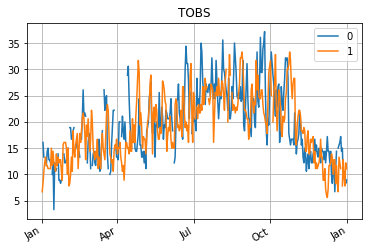

In [11]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

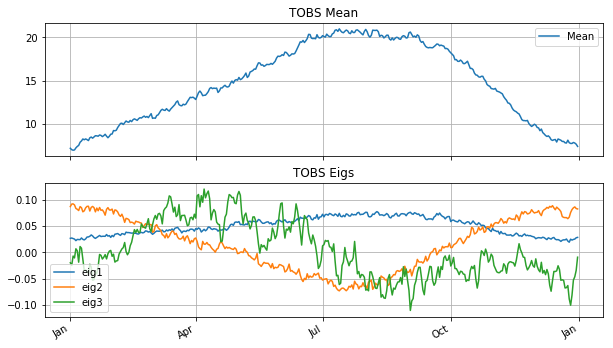

In [12]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']/10
EigVec = EigVec
Mean = Mean
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

In [13]:
cumsum([1,2,3])

array([1, 3, 6])

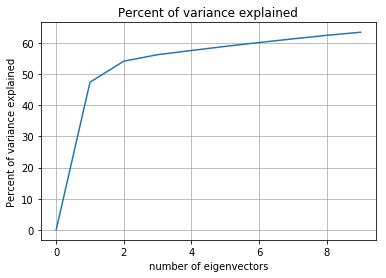

In [14]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [15]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i]/10,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 53.2847370931
residual normalized norm  after mean + top eigs: [ 0.00458347  0.00428291  0.00429473]


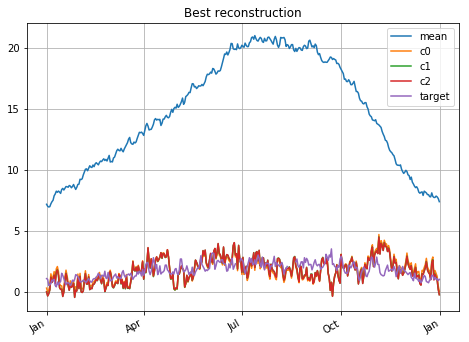

In [16]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [17]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

NameError: name 'decompose' is not defined

In [18]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [19]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1186
after filter 1186


In [91]:
df4=df3.sort(df3.coeff_1,ascending=True)
rows=df4.take(12)

In [104]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if m == 'TOBS':
        target = target/10
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #       %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            _title='c3=%3.2f,r3=%3.2f'%(row['coeff_3'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [86]:
df5=df3.sort(df3.coeff_1,ascending=False)
rows2=df5.take(12)
df5.select('coeff_1','res_1','res_2','res_3').show(4)

+-----------------+--------------------+--------------------+--------------------+
|          coeff_1|               res_1|               res_2|               res_3|
+-----------------+--------------------+--------------------+--------------------+
|4238.408830397506|0.031024518476936366| 0.03026703608994825|0.030085641523470524|
|4159.726613295194| 0.03706425827896865| 0.03692232324374465| 0.03661268436817015|
|4129.973558782231|0.033023241282060425|  0.0323468832578928|0.031680235430301365|
|4128.690391007945|0.042847891384758925|0.042054106231623686| 0.04165385553694186|
+-----------------+--------------------+--------------------+--------------------+
only showing top 4 rows



In [133]:
#Best reconstruction
df10=df3.sort(df3.res_3,ascending=True)
rows10=df10.take(12)
df10.select('res_1','res_2','res_3').show(4)

+-------------------+--------------------+--------------------+
|              res_1|               res_2|               res_3|
+-------------------+--------------------+--------------------+
|0.07418127569090757| 0.02152447795775531|0.021285505723717256|
|0.08100492063253782|0.021733540808255514| 0.02208109554029824|
| 0.0625421311850252| 0.02223851958869275|0.022163626971397628|
|0.06378445643060897|0.022663354289440607|0.022659752311446776|
+-------------------+--------------------+--------------------+
only showing top 4 rows



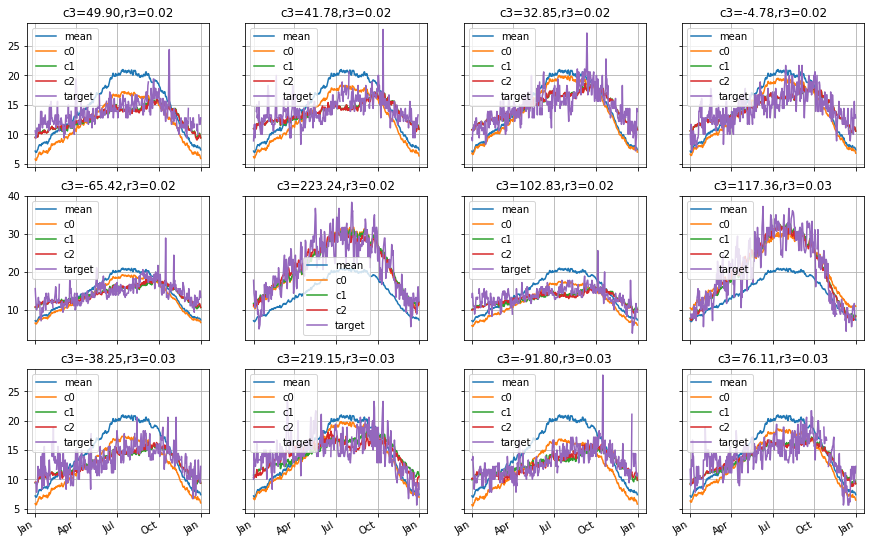

In [134]:
plot_recon_grid(rows10)

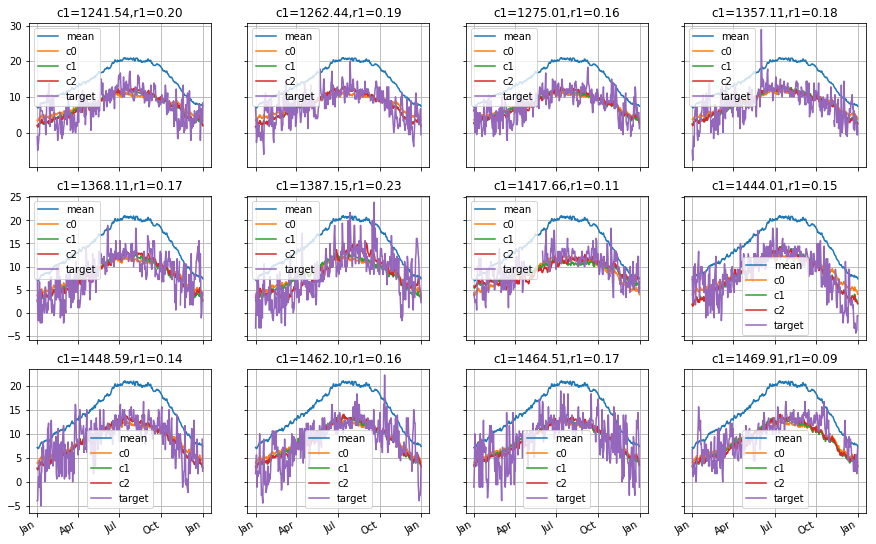

In [93]:
plot_recon_grid(rows)

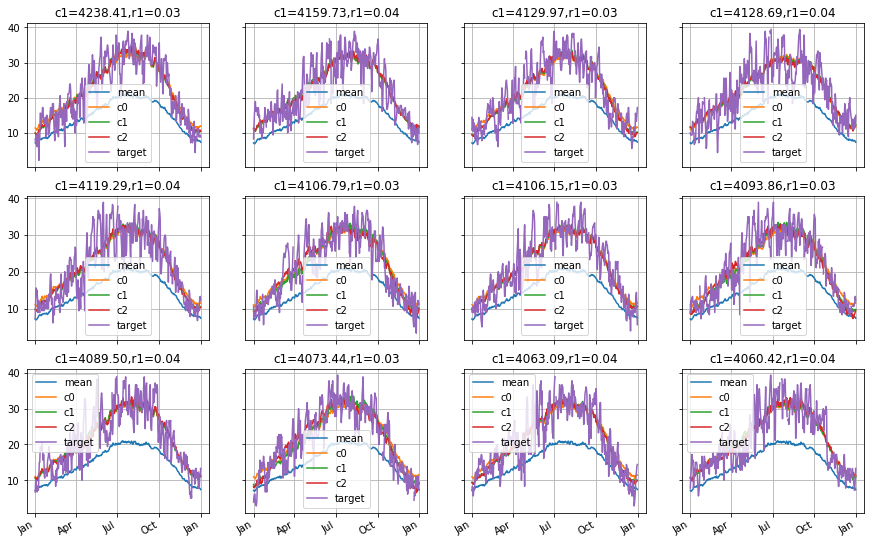

In [87]:
plot_recon_grid(rows2)

In [94]:
df6=df3.sort(df3.coeff_2,ascending=True)
rows3=df6.take(12)
df6.select('coeff_2','res_1','res_2','res_3').show(4)

+------------------+-------------------+-------------------+-------------------+
|           coeff_2|              res_1|              res_2|              res_3|
+------------------+-------------------+-------------------+-------------------+
|-565.8651774494697|0.12116363368714389| 0.0843932885594816|0.08207720882999708|
|-541.8651909083392|0.09429477148208347|0.05680731230499203|0.05363176213961816|
|-531.6619200949914| 0.1154662665234933|0.06739962625052484|0.06233887829001532|
|-529.2190023774705|0.07081055679374595|0.06635047515910662|0.05817274675408739|
+------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



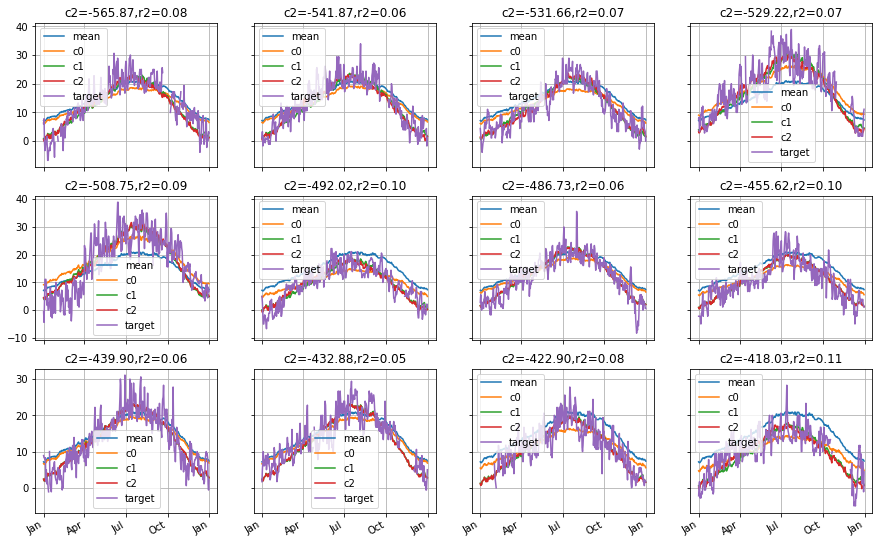

In [97]:
plot_recon_grid(rows3)

In [100]:
df7=df3.sort(df3.coeff_2,ascending=False)
rows4=df7.take(12)
df7.select('coeff_2','res_1','res_2','res_3').show(4)
rows4 = rows4[::-1]

+-----------------+-------------------+-------------------+-------------------+
|          coeff_2|              res_1|              res_2|              res_3|
+-----------------+-------------------+-------------------+-------------------+
|914.9013119474384|0.11876178214778818|0.06454672027635328|0.06383094949875316|
|833.4425863711117|0.13370244227938535|0.11327602680259401|0.11985603989675116|
|821.6083980407944|0.09540245884129245|0.08395550741892667|0.09405943942309375|
|726.7695015670348|0.08550226456042373|0.04823965675737669|0.04870019158260568|
+-----------------+-------------------+-------------------+-------------------+
only showing top 4 rows



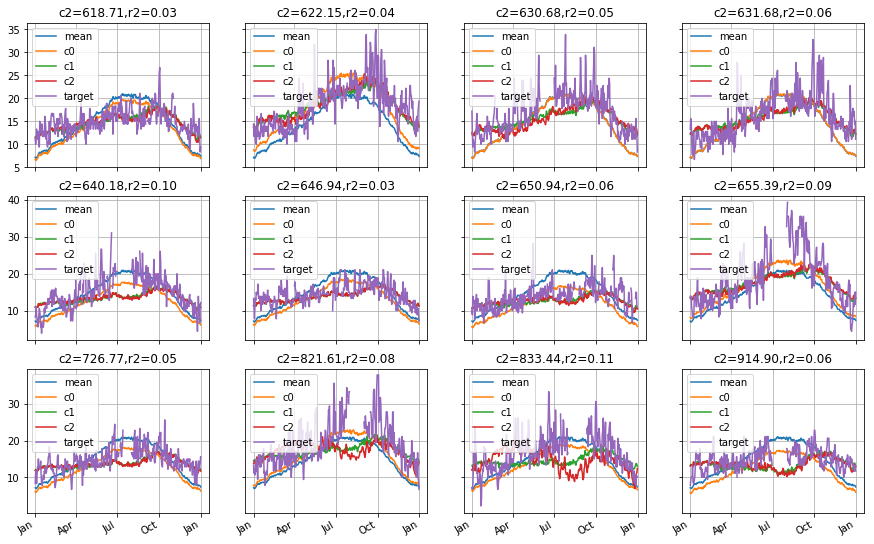

In [101]:
plot_recon_grid(rows4)

+-------------------+-------------------+--------------------+-------------------+
|            coeff_3|              res_1|               res_2|              res_3|
+-------------------+-------------------+--------------------+-------------------+
| -636.0653189974385| 0.1627194027049105| 0.16213217493753984|0.09945081672233654|
| -505.3973612472789| 0.1710840822225584| 0.16982977379391645|0.12905603442403582|
|-478.97487901453525|0.17557529861933732| 0.16457387522721809|0.14638991787418734|
|-459.60304235904283| 0.0514711510870886|0.050122778671395356|0.03534251650131389|
+-------------------+-------------------+--------------------+-------------------+
only showing top 4 rows



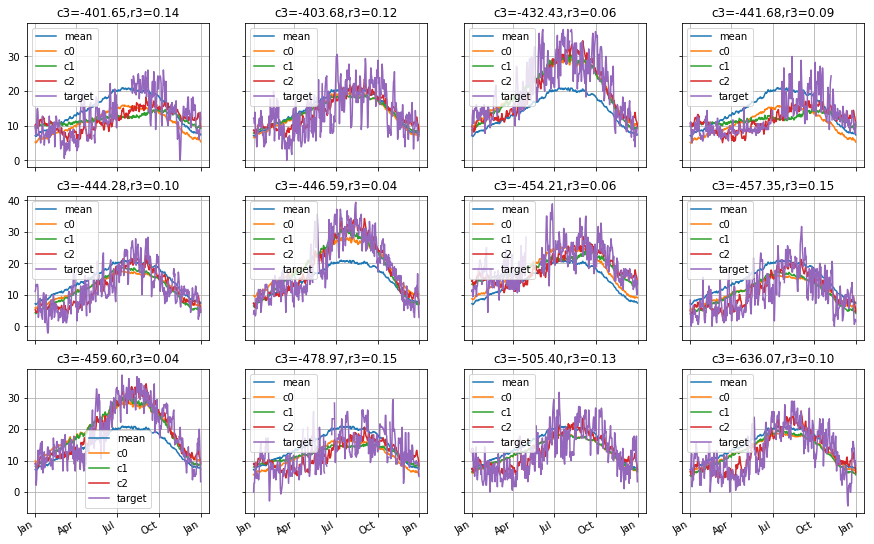

In [105]:
df8=df3.sort(df3.coeff_3,ascending=True)
rows5=df8.take(12)
df8.select('coeff_3','res_1','res_2','res_3').show(4)
rows5 = rows5[::-1]
plot_recon_grid(rows5)

+-----------------+-------------------+-------------------+-------------------+
|          coeff_3|              res_1|              res_2|              res_3|
+-----------------+-------------------+-------------------+-------------------+
| 867.892914231813| 0.1404788662804142| 0.1502184342096731|0.10892645702257601|
|680.5395142425995|0.08177833001453211|0.09071100047175665|0.09364228038985416|
|602.3604824512312|0.13370244227938535|0.11327602680259401|0.11985603989675116|
|544.2225771482139|0.11321468628129525|0.11303295877481476| 0.0797286389022325|
+-----------------+-------------------+-------------------+-------------------+
only showing top 4 rows



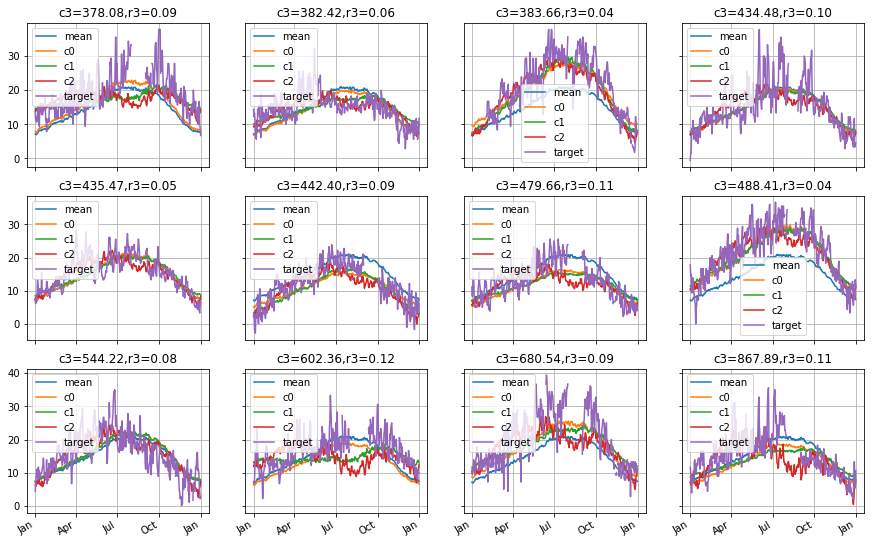

In [106]:
df9=df3.sort(df3.coeff_3,ascending=False)
rows6=df9.take(12)
df9.select('coeff_3','res_1','res_2','res_3').show(4)
rows6 = rows6[::-1]
plot_recon_grid(rows6)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

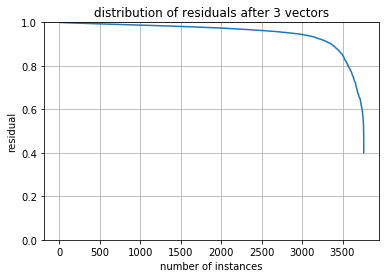

In [94]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [22]:
df8=df3.sort(df3.res_3,ascending=True)

In [110]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df8.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)+1))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

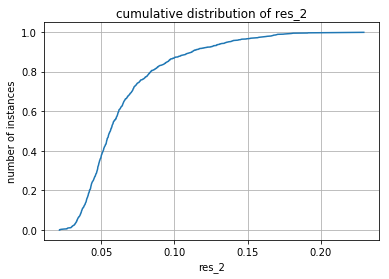

In [111]:
plot_CDF('res_2')

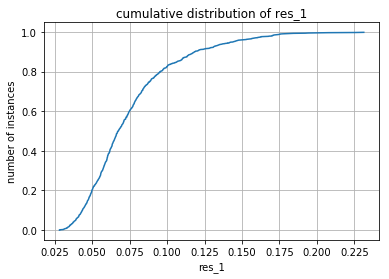

In [112]:
plot_CDF('res_1')

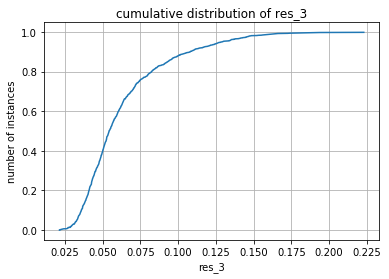

In [113]:
plot_CDF('res_3')

In [20]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat1,feat2,feat3,label):
    rows1=df8.select(feat1).sort(feat1).collect()
    vals1=[r[feat1] for r in rows1]
    P1=np.arange(0,1,1./(len(vals1)+1))
    vals1=[vals1[0]]+vals1
    rows2=df8.select(feat2).sort(feat2).collect()
    vals2=[r[feat2] for r in rows2]
    vals2=[vals2[0]]+vals2
    P2=np.arange(0,1,1./(len(vals2)))
    rows3=df8.select(feat3).sort(feat3).collect()
    vals3=[r[feat3] for r in rows3]
    vals3=[vals3[0]]+vals3
    P3=np.arange(0,1,1./(len(vals3)))
    plot(vals1,P1,label=feat1)
    plot(vals2,P2,label=feat2)
    plot(vals3,P3,label=feat3)
    title('cumulative distribution of Coefficients')
    ylabel('number of instances')
    xlabel(label)
    legend()
    grid()

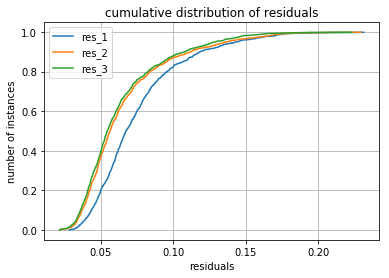

In [143]:
plot_CDF('res_1','res_2','res_3','residuals')

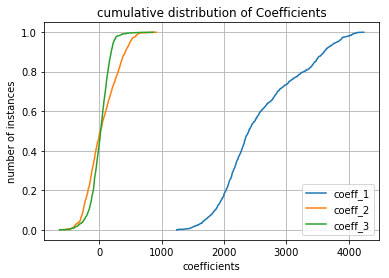

In [23]:
plot_CDF('coeff_1','coeff_2','coeff_3','coefficients')

In [138]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df8.write.parquet(filename)

In [139]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.4M	../../Data/Weather/US_Weather_SBBBBBSB.parquet
3.1M	../../Data/Weather/US_Weather_SSSBSSSB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
3.9M	../../Data/Weather/decon_BBBSBBBB_PRCP.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.9M	../../Data/Weather/decon_SBBBBBSB_PRCP.parquet
2.3M	../../Data/Weather/decon_SBBBBBSB_SNWD.parquet
3.1M	../../Data/Weather/decon_SSSBSSSB_TOBS.parquet


In [140]:
filename

'../../Data/Weather/decon_SSSBSSSB_TOBS.parquet'